## TO DO

At the cell that starts with train_ds = RetinaDataset(pathTo250s, X_train, y_train), output image is really weird looking. Making sure the image is more human-interpretable on that cell might improve model score.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from sklearn import metrics

#!sudo pip3 install opencv-python
import cv2



PATH = Path("/home/ubuntu/data")
X = list((PATH/"train").iterdir())
len(X), X[:20]

(35126,
 [PosixPath('/home/ubuntu/data/train/23104_left.jpeg'),
  PosixPath('/home/ubuntu/data/train/42184_right.jpeg'),
  PosixPath('/home/ubuntu/data/train/23287_right.jpeg'),
  PosixPath('/home/ubuntu/data/train/26100_right.jpeg'),
  PosixPath('/home/ubuntu/data/train/18101_right.jpeg'),
  PosixPath('/home/ubuntu/data/train/20499_right.jpeg'),
  PosixPath('/home/ubuntu/data/train/7544_right.jpeg'),
  PosixPath('/home/ubuntu/data/train/20255_right.jpeg'),
  PosixPath('/home/ubuntu/data/train/19949_right.jpeg'),
  PosixPath('/home/ubuntu/data/train/40220_left.jpeg'),
  PosixPath('/home/ubuntu/data/train/25871_right.jpeg'),
  PosixPath('/home/ubuntu/data/train/30058_left.jpeg'),
  PosixPath('/home/ubuntu/data/train/33535_left.jpeg'),
  PosixPath('/home/ubuntu/data/train/33531_left.jpeg'),
  PosixPath('/home/ubuntu/data/train/40622_right.jpeg'),
  PosixPath('/home/ubuntu/data/train/10988_left.jpeg'),
  PosixPath('/home/ubuntu/data/train/20979_left.jpeg'),
  PosixPath('/home/ubuntu/data/

In [2]:
## Show an image and label here.

## Auxiliary Operations

In [3]:
#IMAGE OPERATIONS



import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def center_crop_square(im):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def get_a_crop(path, sz=250):
    im = cv2.imread(str(path))
    return cv2.resize(center_crop_square(im), (sz, sz))

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def normalize(im):  #bunu zaten /255 işleminden geçmiş image'lara yapıyor.
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

## Resizing Images

In [4]:
'''Create path for resized images given size such as dataset-450 or valid-250.'''

def createResizedImagesFolder(pathToImages, pathToFolder, size):  #Takes str of PosixPath, returns PosixPath
    pathToImages = Path(pathToImages)
    Path(pathToFolder).mkdir(parents=True, exist_ok=True)
    pathToFolder = Path(pathToFolder)
    
    if len(list(pathToFolder.iterdir())) == 0:  # Means we havent created any image in this folder yet
        for p in pathToImages.iterdir():
            img = get_a_crop(p, size)
            fileName = str(p).split('/')[-1]
            cv2.imwrite(str(pathToFolder/fileName), img)
    else:  #Means we have been here before.
        print(str(pathToFolder) + ' already exists. No images resized.')
        
    return pathToFolder

In [5]:
pathTo250s = createResizedImagesFolder(PATH/'train', PATH/'images-250', 250)
list(pathTo250s.iterdir())[:10]

/home/ubuntu/data/images-250 already exists. No images resized.


[PosixPath('/home/ubuntu/data/images-250/23104_left.jpeg'),
 PosixPath('/home/ubuntu/data/images-250/42184_right.jpeg'),
 PosixPath('/home/ubuntu/data/images-250/23287_right.jpeg'),
 PosixPath('/home/ubuntu/data/images-250/26100_right.jpeg'),
 PosixPath('/home/ubuntu/data/images-250/18101_right.jpeg'),
 PosixPath('/home/ubuntu/data/images-250/20499_right.jpeg'),
 PosixPath('/home/ubuntu/data/images-250/7544_right.jpeg'),
 PosixPath('/home/ubuntu/data/images-250/20255_right.jpeg'),
 PosixPath('/home/ubuntu/data/images-250/19949_right.jpeg'),
 PosixPath('/home/ubuntu/data/images-250/40220_left.jpeg')]

## Importing X and y, train/valid split (Find a better name for this heading)

In [6]:
#PATH/"trainLabels.csv"
#X must consist of full names of images only.
#path before filename will be added on RetinaDataset.
df = pd.read_csv(PATH/"trainLabels.csv")
X = list(df['image'])
X = [filename + '.jpeg' for filename in X]
X[:10], len(X)

(['10_left.jpeg',
  '10_right.jpeg',
  '13_left.jpeg',
  '13_right.jpeg',
  '15_left.jpeg',
  '15_right.jpeg',
  '16_left.jpeg',
  '16_right.jpeg',
  '17_left.jpeg',
  '17_right.jpeg'],
 35126)

In [7]:
y = list(df['level'])
y[:10], len(y)

([0, 0, 0, 0, 1, 2, 4, 4, 0, 1], 35126)

In [8]:
from sklearn.model_selection import train_test_split
#Beware, the line below returns pandas.Series objects. Convert them to lists first.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=0)
X_train = list(X_train)
X_valid = list(X_valid)
y_train = list(y_train)
y_valid = list(y_valid)

#Checking out this line. It should look okay
len(X_train), len(X_valid), len(y_train), len(y_valid)

(28100, 7026, 28100, 7026)

In [9]:
#Print an image and label here.

## Creating Dataset / DataLoader

In [10]:
class RetinaDataset(Dataset):
    def __init__(self, path, X, y=None, transforms=False):
        self.X = X
        self.y = y  #Burada self.y=None yaptığından emin olman lazım çünkü if self.y case'leri mevcut.
        self.transforms = transforms
        self.path = path
        
    def __len__(self):
        return len(self.y)

    
    def __getitem__(self, idx):
        path = str(self.path) + "/" + str(self.X[idx])
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:  #Brings a random augmentation.
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            x = random_crop(x)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
        else:  #Here, she center crops. However, don't do that for the fishes. You'll lose your fish.
            x = center_crop(x)
        x = normalize(x)
        
        if self.y:
            return np.rollaxis(x, 2), self.y[idx]
        else:
            return np.rollaxis(x, 2)
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 234, 234)
1


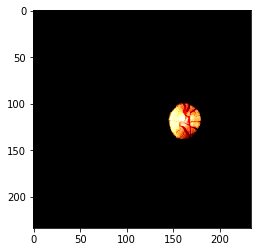

In [11]:
train_ds = RetinaDataset(pathTo250s, X_train, y_train)
valid_ds = RetinaDataset(pathTo250s, X_valid, y_valid)

#Check if Dataset works properly
x, y = train_ds[np.random.randint(len(train_ds))]
print(x.shape), print(y)
plt.imshow(np.rollaxis(np.rollaxis(x, 2), 2), cmap='gray')

In [12]:
len(train_ds), len(valid_ds)

(28100, 7026)

In [13]:
bs = 64
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs)
CUDA_LAUNCH_BLOCKING=1

In [14]:
x, y = next(iter(train_dl))
x = x.cuda().float()
y = y.cuda().float()
x.shape, y.shape

(torch.Size([64, 3, 234, 234]), torch.Size([64]))

## Model

In [15]:
resnet = models.resnet34(pretrained=True)

In [16]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]  #Last two layers out of 10 layers

10


[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [96]:
# This model will be right after the 8th layer of resnet.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():  #resnet.parameters() is a generator object.
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        #burada top modeldan kasti image'a yakin olan taraf.
        self.top_model = nn.Sequential(*layers).cuda()
        self.fc = nn.Linear(512, 5)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.size(0), -1) # flattening 
        x = self.fc(x)
        return x

In [97]:
model = Net().cuda()

In [98]:
x, y = next(iter(train_dl))
x = x.cuda().float()
y = y.cuda().float()
x.shape, y.shape, type(x), type(y)

(torch.Size([64, 3, 234, 234]), torch.Size([64]), torch.Tensor, torch.Tensor)

## val_metrics

In [211]:
def val_metrics(model, valid_dl, explanatoryMetrics=True):
    model.eval()
    
    #add more metrics here.
    #Do the 1x overestimation 1x underestimation ,2x over etc etc...
    total = 0
    sum_loss = 0
    correct = 0
    
    labels = []
    preds = []
    
    for x, y in valid_dl:
        x = x.cuda().float()
        y = y.cuda()  #bunu .unsqueeze(1) yaptigin an error veriyor.
        out = model(x)  #Here, out has a shape of bs x 5. Gotta convert that into one variable.
        
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        #if above doesnt work use this line
        #correct += pred.eq(y.data).sum().item()
        loss = F.cross_entropy(out, y)
        
        #labels.append(list(y.detach().cpu().numpy()))
        #preds.append(list(pred.detach().cpu().numpy()))
        
        labels += list(y.detach().cpu().numpy())
        preds += list(pred.detach().cpu().numpy())
        
        batch = y.shape[0]
        sum_loss += batch*(loss.item())
        total += batch
        
    
    #Get Quadratic Kappa
    qkappa = metrics.cohen_kappa_score(labels,
                                   preds,
                                   weights="quadratic")
    
    #Get Explanatory Metrics
    #predDifferences = preds-labels
    
    return sum_loss/total, correct/total, qkappa #Returns loss, accuracy, quadratic weighted kappa
    #Also return quadratic weighted kappa here.

In [212]:
val_metrics(model, valid_dl)

[0, 2, 0]
[1, 1, 1]
50
7026
7026
<class 'list'>
<class 'list'>
7026


(2.0065630698794488, 0.0677483632223171, 0.0005831640416987804)

7026

## Learning Rate Finder

In [104]:
#Here, what filter does is that, he runs the lambda function for each element in model.paramterers()
#If it turns out true, it gets into the parameters variable.
#In other words, parameters has the non-frozen parameters only.
def get_optimizer(model, lr = 0.01, wd = 0.0):  #Brings non-frozen parameters.
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def update_optimizer(optimizer, lr):  #Updates the learning rate.
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr
        
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))
    
#Here, this guy increases learning rate bit by bit. Outputs a graph of loss function.
#In the graph, loss function will go down until a point where it will start to go crazy up and down.
#In other words, after a value of learning rate, it won't be able to converge. It'll go crazy.
#You want to pick a learning rate before that point.
#So that you can converge smoothly.
#You keep updating the parameters of your model. However, you change learning rate every iteration.
#number of iterations: number of epochs * batch size
def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    optimizer = get_optimizer(model, lr = lrs[0], wd = 0.0)
    for i in range(epochs):
        for x,y in train_dl:
            update_optimizer(optimizer, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 



In [107]:
model = Net().cuda()  #Bu line ile sanirim modelini GPU'da initialize ediyorsun.
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-10, lr_high=1e-3)

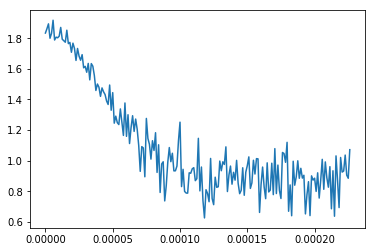

In [108]:
plt.plot(lrs[:200], losses[:200])
plt.show()

## Train

In [213]:
def train(model, epochs=5, learning_rate=0.01):
    optimizer = get_optimizer(model, lr = learning_rate, wd =0)
    for i in range(epochs):
        model.train()  #Do this here because in val_metrics, model.eval() runs.
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            
            loss = F.cross_entropy(out, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            total += batch
            sum_loss += batch*(loss.item())
            
        val_loss, val_acc, val_kappa = val_metrics(model, valid_dl)  #Her bir epoch'da validation set ile test ediyorsun.
        print("train loss %.3f val loss %.3f val accuracy %.3f val kappa %.3f" % (sum_loss/total, val_loss, val_acc, val_kappa))
    

In [214]:
model = Net().cuda()
train(model)

[0, 2, 0]
[0, 0, 3]
50
7026
7026
<class 'list'>
<class 'list'>
7026
train loss 0.935 val loss 1.042 val accuracy 0.623 val kappa 0.329
[0, 2, 0]
[0, 0, 2]
50
7026
7026
<class 'list'>
<class 'list'>
7026
train loss 0.872 val loss 0.913 val accuracy 0.681 val kappa 0.381
[0, 2, 0]
[0, 0, 2]
50
7026
7026
<class 'list'>
<class 'list'>
7026
train loss 0.865 val loss 1.040 val accuracy 0.605 val kappa 0.295
[0, 2, 0]
[0, 0, 2]
50
7026
7026
<class 'list'>
<class 'list'>
7026
train loss 0.876 val loss 0.963 val accuracy 0.622 val kappa 0.329
[0, 2, 0]
[0, 0, 2]
50
7026
7026
<class 'list'>
<class 'list'>
7026
train loss 0.907 val loss 0.911 val accuracy 0.709 val kappa 0.366


In [215]:
val_metrics(model, valid_dl)

[0, 2, 0]
[0, 0, 2]
50
7026
7026
<class 'list'>
<class 'list'>
7026


(0.9108756109584338, 0.7090805579276971, 0.36617075551337064)

In [216]:
#modelin parametrelerini True ya da False yapiyorsun. Tüm parametreleri ama.
#O yüzden bunu modelin bir kısmını seçip run ediyorsun.
#Mesela Sequential modelin birkaç layerını seçip kullanabilirsin.
#a layer is a model too, I think
def set_trainable_attr(m, b=True):  #b=True yani it unfreezes by default.
    for p in m.parameters(): p.requires_grad = b
        
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])  #Mesela top_model içinde layerler olan bir list. İstediğin layerı unfreeze et.
    
#Zaten 8 layer var. 7 ve 6. indexdekiler en sonuncuları.
unfreeze(model, 7)
unfreeze(model, 6)

In [217]:
# lower learning rate
# 5 posta daha train ediyorum. Bu sefer layerlarin birazini unfreeze ederek.
# val loss iyice azaliyor gibi.
train(model, epochs=5, learning_rate=0.0001)

[0, 2, 0]
[0, 0, 0]
50
7026
7026
<class 'list'>
<class 'list'>
7026
train loss 0.750 val loss 0.727 val accuracy 0.772 val kappa 0.498
[0, 2, 0]
[0, 0, 0]
50
7026
7026
<class 'list'>
<class 'list'>
7026
train loss 0.587 val loss 0.692 val accuracy 0.765 val kappa 0.523
[0, 2, 0]
[0, 0, 1]
50
7026
7026
<class 'list'>
<class 'list'>
7026
train loss 0.433 val loss 0.773 val accuracy 0.752 val kappa 0.546
[0, 2, 0]
[0, 0, 1]
50
7026
7026
<class 'list'>
<class 'list'>
7026
train loss 0.243 val loss 0.984 val accuracy 0.733 val kappa 0.577
[0, 2, 0]
[0, 0, 1]
50
7026
7026
<class 'list'>
<class 'list'>
7026
train loss 0.150 val loss 1.054 val accuracy 0.725 val kappa 0.557


## The Very Bottom Part of this doc is for testing

In [131]:
model = Net().cuda()

In [132]:
x, y = next(iter(train_dl))
x = x.cuda().float()
y = y.cuda().float()
x.shape, y.shape, type(x), type(y)
out = model(x)
_, pred = torch.max(out, 1)

In [133]:
pred

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1], device='cuda:0')

In [134]:
out

tensor([[-8.2738e-01,  4.3935e-01, -2.0654e-01, -4.9658e-01, -1.0522e+00],
        [-7.5172e-01,  3.5475e-01, -3.7029e-01, -4.8058e-01, -9.9944e-01],
        [-7.9705e-01,  3.6043e-01,  1.8179e-01, -4.9183e-01, -1.0892e+00],
        [-1.0630e+00,  1.2893e+00, -6.7064e-01, -5.8770e-01, -8.9687e-01],
        [-7.2993e-01,  1.2086e+00, -3.8347e-01, -5.4394e-01, -7.4223e-01],
        [-1.1183e+00,  8.1864e-01, -5.8624e-01, -1.1010e+00, -1.5238e+00],
        [-7.5229e-01, -1.3334e-03, -5.8160e-01, -3.6901e-01, -4.0382e-01],
        [-5.9850e-01,  5.9732e-01, -3.2639e-01,  8.1230e-02, -1.0396e+00],
        [-1.5461e+00,  4.9414e-01, -7.9799e-01, -2.6335e-01, -1.2811e+00],
        [-1.1934e+00,  1.8424e-02, -1.2202e-03,  3.2946e-03, -1.0564e+00],
        [-1.5891e+00,  2.3360e-01, -6.2440e-01, -9.7288e-02, -1.0854e+00],
        [-5.5202e-01,  4.8498e-01, -5.0822e-01, -2.5746e-01, -9.5653e-01],
        [-1.2583e+00,  4.1151e-01, -5.7392e-01,  3.3230e-01, -1.8313e+00],
        [-8.4040e-01,  8.

In [135]:
y

tensor([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 4., 0., 0., 0., 0., 2., 0., 0.,
        0., 2., 0., 0., 0., 3., 2., 0., 2., 2., 0., 0., 0., 3., 2., 2., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2., 0., 2., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 2., 0., 2., 0., 0.], device='cuda:0')

In [141]:
qkappa = metrics.cohen_kappa_score(y.detach().cpu().numpy(),
                                   pred.detach().cpu().numpy(),
                                   weights="quadratic")


In [142]:
qkappa

0.03961584633853543

In [205]:
anan = [[1, 2, 3], [3, 4, 5], [6, 7]]
anan

#list(np.vstack(anan).reshape(-1))
anan.view(-1)

AttributeError: 'list' object has no attribute 'view'

In [191]:
type(np.vstack(anan))

numpy.ndarray